In [13]:
%%capture
import warnings
warnings.filterwarnings('ignore')  #suppress some warnings about future code changes

import pandas as pd
import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html
#import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
from scipy import stats    #Used for 2D binned statistics
from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import pyicon as pyic
import glob, os  
from netCDF4 import Dataset, num2date

import sys
from os import path 
from pathlib import Path 
from eval_funcs import *

# Argo climatology Grid

In [2]:
path_data = '/work/mh0033/from_Mistral/mh0033/u241317/argo/Argo_mixedlayers_monthlyclim_03172021.nc'
da = xr.open_dataset(path_data)
da

<xarray.Dataset>
Dimensions:        (iLAT: 180, iLON: 360, iMONTH: 12)
Dimensions without coordinates: iLAT, iLON, iMONTH
Data variables: (12/20)
    lat            (iLAT) float64 ...
    lon            (iLON) float64 ...
    month          (iMONTH) float64 ...
    mld_da_mean    (iLAT, iLON, iMONTH) float64 ...
    mld_dt_mean    (iLAT, iLON, iMONTH) float64 ...
    mld_da_median  (iLAT, iLON, iMONTH) float64 ...
    ...             ...
    mlt_dt         (iLAT, iLON, iMONTH) float64 ...
    mls_da         (iLAT, iLON, iMONTH) float64 ...
    mls_dt         (iLAT, iLON, iMONTH) float64 ...
    num            (iLAT, iLON, iMONTH) float64 ...
    longrid        (iLAT, iLON) float64 ...
    latgrid        (iLAT, iLON) float64 ...
Attributes:
    description:  This file was created using \n matlab R2011b with NETCDF Li...
    date:         [730848.53015047 730848.88790506 730849.28543982 ... 738207...

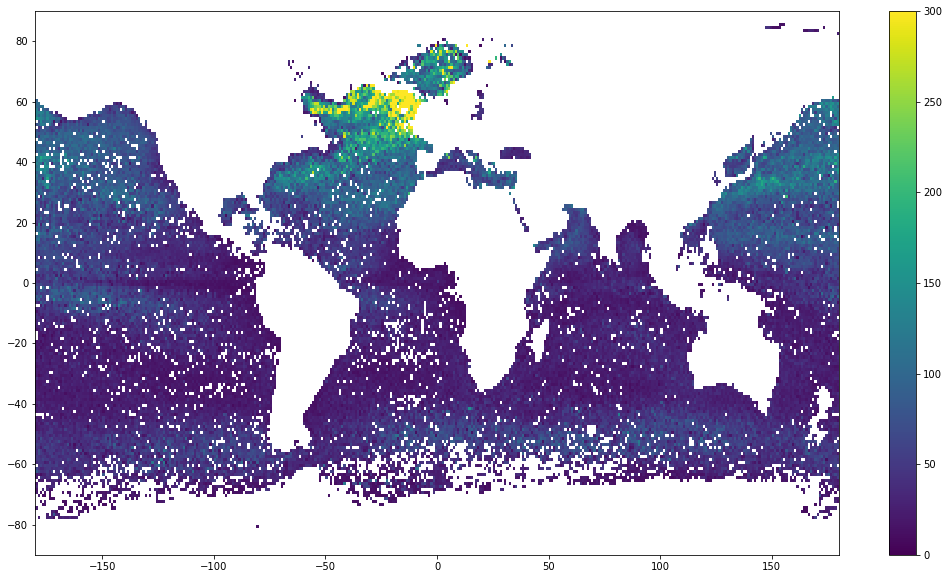

In [3]:
fig = plt.figure(figsize=(18,10))
plt.pcolormesh(da.longrid, da.latgrid, da.mld_da_mean.isel(iMONTH=0),vmin=0, vmax=300)
plt.colorbar()

In [4]:
da.longrid

<xarray.DataArray 'longrid' (iLAT: 180, iLON: 360)>
array([[-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5],
       [-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5],
       [-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5],
       ...,
       [-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5],
       [-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5],
       [-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5]])
Dimensions without coordinates: iLAT, iLON
Attributes:
    long_name:        Longitude grid
    standard_name:    longrid
    units:            Degrees east
    _CoordinateAxis:  month lat lon
    valid_min:        100.0
    valid_max:        114.0
    title:            Longitude grid
    institution:      SIO

In [5]:
da.latgrid

<xarray.DataArray 'latgrid' (iLAT: 180, iLON: 360)>
array([[-89.5, -89.5, -89.5, ..., -89.5, -89.5, -89.5],
       [-88.5, -88.5, -88.5, ..., -88.5, -88.5, -88.5],
       [-87.5, -87.5, -87.5, ..., -87.5, -87.5, -87.5],
       ...,
       [ 87.5,  87.5,  87.5, ...,  87.5,  87.5,  87.5],
       [ 88.5,  88.5,  88.5, ...,  88.5,  88.5,  88.5],
       [ 89.5,  89.5,  89.5, ...,  89.5,  89.5,  89.5]])
Dimensions without coordinates: iLAT, iLON
Attributes:
    long_name:        Latitude grid
    standard_name:    latgrid
    units:            Degrees north
    _CoordinateAxis:  month lat lon
    valid_min:        97.0
    valid_max:        116.0
    title:            Latitude grid
    institution:      SIO

In [7]:
da.lon[1]-da.lon[0]

<xarray.DataArray 'lon' ()>
array(1.)

In [8]:
da.lat[1]-da.lat[0]

<xarray.DataArray 'lat' ()>
array(1.)

In [9]:
print(da.lat.max(),da.lat.min(),da.lon.max(),da.lon.max())

<xarray.DataArray 'lat' ()>
array(89.5) <xarray.DataArray 'lat' ()>
array(-89.5) <xarray.DataArray 'lon' ()>
array(179.5) <xarray.DataArray 'lon' ()>
array(179.5)


## sst satellite grid

In [15]:
sat = load_satellite_sst()
sat

<xarray.Dataset>
Dimensions:       (lat: 4320, lon: 8640, time: 90)
Coordinates:
  * lat           (lat) float32 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon           (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time          (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-03-31
Data variables:
    sst_night     (time, lat, lon) float32 dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    sst_night_qf  (time, lat, lon) float32 dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    sst_day       (time, lat, lon) float32 dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    sst_day_qf    (time, lat, lon) float32 dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
Attributes: (12/27)
    Conventions:                CF-1.6
    title:                      MODIS-AQUA Collection 6 daily (mean) sea surf...
    summary:                    MODIS-AQUA Collection 6 daily (mean) sea surf...
    institution:                Center for Earth System Research and Sustaina...
    creator_url:                http://icdc.cen.uni-hamburg.de
    creator_name:               Integrated Climate Data Center (ICDC)
    ...                         ...
    platform:                   EOS-AQUA
    sensor:                     MODIS
    version:                    R2014.0
    source:                     http://oceandata.sci.gsfc.nasa.gov/MODIS-Aqua...
    references:                 1) http://oceancolor.gsfc.nasa.gov/cms/techdo...
    citation:                   NASA Goddard Space Flight Center, Ocean Ecolo...

In [16]:
sat.lat[1]-sat.lat[0]

<xarray.DataArray 'lat' ()>
array(-0.04166412, dtype=float32)

In [18]:
sat.lon[1]-sat.lon[0]

<xarray.DataArray 'lon' ()>
array(0.04167175, dtype=float32)

In [19]:
print(sat.lon.max(),sat.lon.min(),sat.lat.max(),sat.lat.min())

<xarray.DataArray 'lon' ()>
array(179.97917, dtype=float32) <xarray.DataArray 'lon' ()>
array(-179.97917, dtype=float32) <xarray.DataArray 'lat' ()>
array(89.979164, dtype=float32) <xarray.DataArray 'lat' ()>
array(-89.97918, dtype=float32)


## SSH Aviso satellite grid

In [21]:
ssh = load_satellite()
ssh

<xarray.Dataset>
Dimensions:         (time: 90, latitude: 720, nv: 2, longitude: 1440)
Coordinates:
  * time            (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-03-31
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
Data variables: (12/14)
    crs             (time) int32 -2147483647 -2147483647 ... -2147483647
    lat_bnds        (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds        (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    sla             (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    adt             (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    tpa_correction  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2010-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2009-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

In [22]:
ssh.latitude[1]-ssh.latitude[0]

<xarray.DataArray 'latitude' ()>
array(0.25, dtype=float32)

In [23]:
ssh.longitude[1]-ssh.longitude[0]

<xarray.DataArray 'longitude' ()>
array(0.25, dtype=float32)

In [24]:
print(ssh.longitude.max(), ssh.longitude.min(), ssh.latitude.max(), ssh.latitude.min())

<xarray.DataArray 'longitude' ()>
array(179.875, dtype=float32) <xarray.DataArray 'longitude' ()>
array(-179.875, dtype=float32) <xarray.DataArray 'latitude' ()>
array(89.875, dtype=float32) <xarray.DataArray 'latitude' ()>
array(-89.875, dtype=float32)


In [30]:
os.getcwd()

'/home/m/m300878/submesoscaletelescope/notebooks/february22'